In [1]:
import numpy as np
import os
import timm
import torch
import time
import torch
import psutil
from torch import nn
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


os.environ["COLAB"] = "False"
# Changing directory into aml_itu
if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')

from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

MPS device found.


In [2]:
MODEL_NAME = 'EfficientNet-b1_90acc'

# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))

# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

In [3]:
def test(model, dataloader, device):
    """Test loop"""
    # Setup test accuracy
    test_acc = 0
    
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)
            
            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Accuracy {test_acc / len(dataloader)}')
    return images, classes, predictions, predictions_argmax

# Load Model weights

In [4]:
# Model Setup
model_name = 'efficientnet_b1'
model = timm.create_model(model_name, pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, 10)
)

# Load the saved model weights
model_load_path = 'outputs/EfficientNet/best_model_epoch_3.pth'
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('mps')))
model = model.to(device)

In [5]:
# IMG Transformations
augmentations = {
    'train': v2.Compose([
    # v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop((168, 224), antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val+test': v2.Compose([
    T.Resize((168, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val+test'], 
                            target_transform=target_transform)

print(f'Lenght of test data: {len(test_data)}')

Lenght of test data: 4670


In [6]:
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [7]:
model.eval()
t = test(model, test_dataloader, device)

Test Accuracy 0.9220278867303509


In [12]:
def test_inference_time(model, dataloader, device):
    test_acc = 0
    total_time = 0

    # Function to print memory usage
    def print_memory_usage():
        process = psutil.Process()
        memory_info = process.memory_info()
        print(f"Memory Usage: {memory_info.rss / (1024 * 1024)} MB")  # Convert bytes to MB

    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            imgs, labels = data
            imgs, labels = imgs.to(device), labels.to(device)

            # Print memory usage before inference
            #print("Before Inference:")
            #print_memory_usage()

            start_time = time.time()  # Start time
            prediction = model(imgs)
            end_time = time.time()  # End time

            # Print memory usage after inference
            #print("After Inference:")
            #print_memory_usage()

            total_time += (end_time - start_time)  # Add to total time
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()

    avg_inference_time = round(total_time / len(dataloader), 4)

    test_acc = round(test_acc / len(dataloader), 4)
    print(f'Test Accuracy {test_acc}')
    print(f'Average Inference Time per Batch: {avg_inference_time} seconds')

#test model
model.eval()
test_inference_time(model, test_dataloader, device)


Test Accuracy 0.8942
Average Inference Time per Batch: 0.1153 seconds


In [11]:
for i, data in enumerate(test_dataloader):
    imgs, labels = data
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Forward pass
    prediction = model(imgs)
    
    break

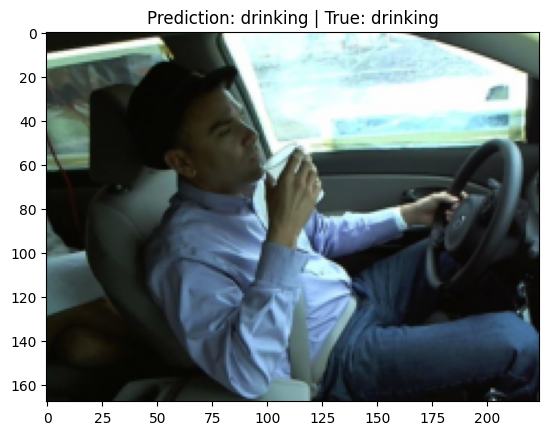

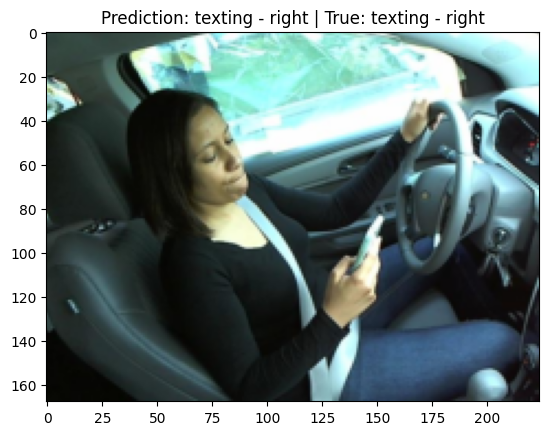

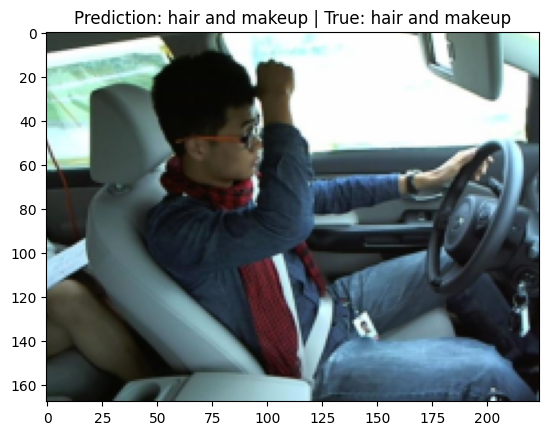

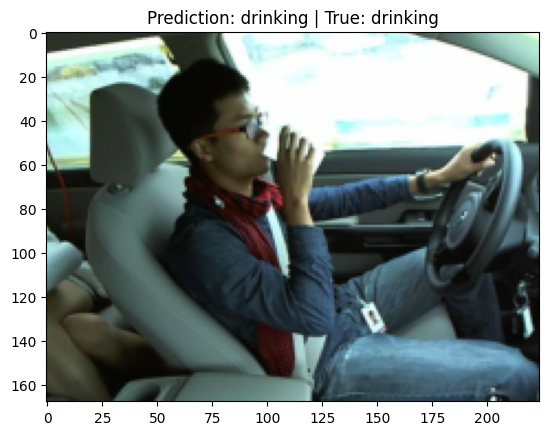

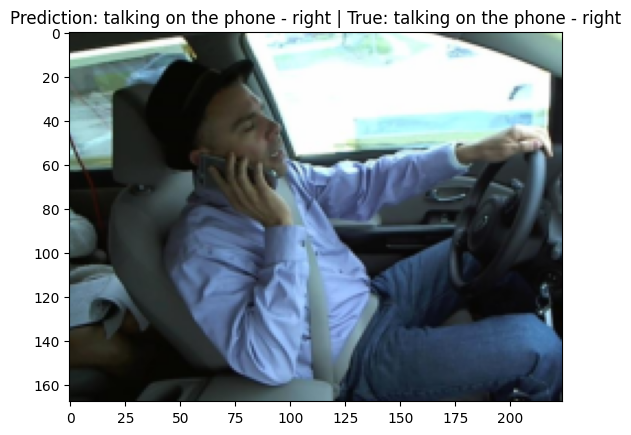

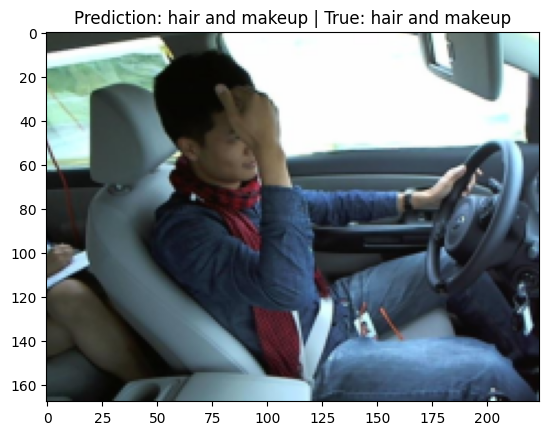

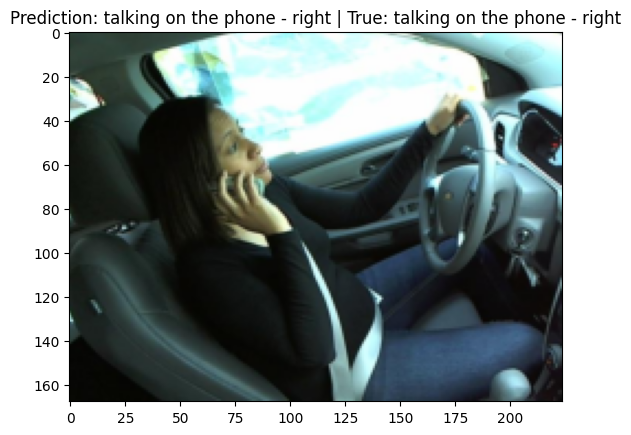

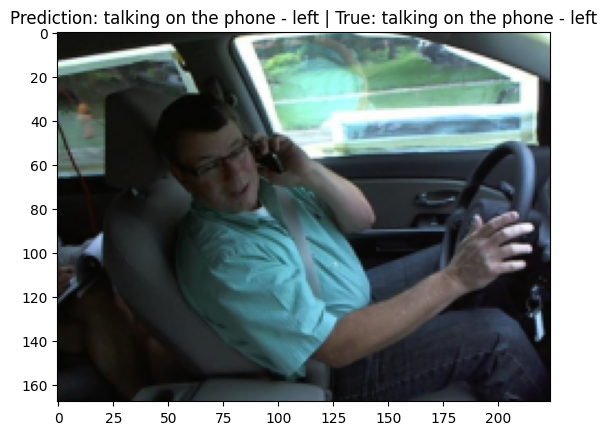

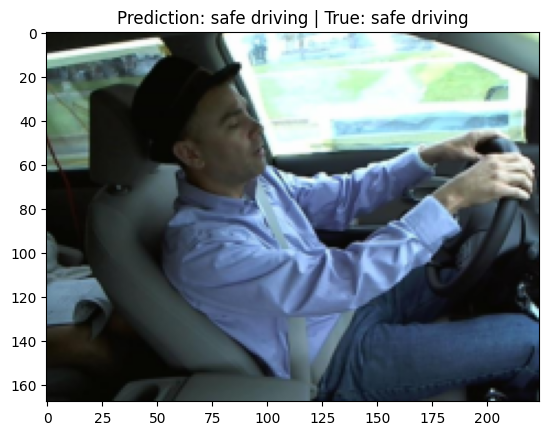

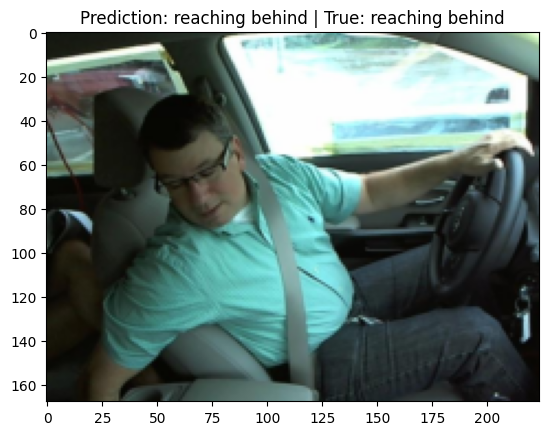

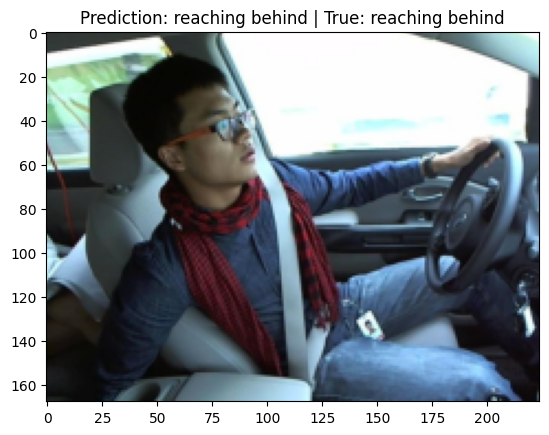

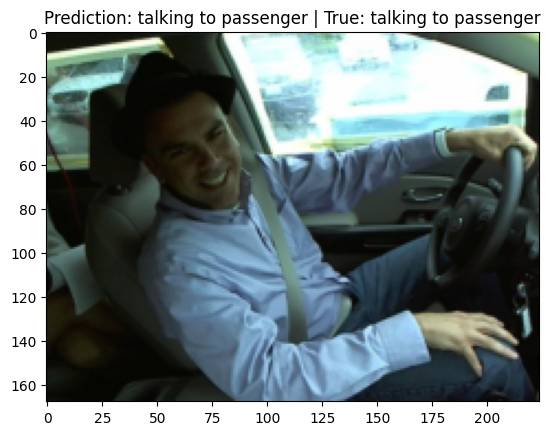

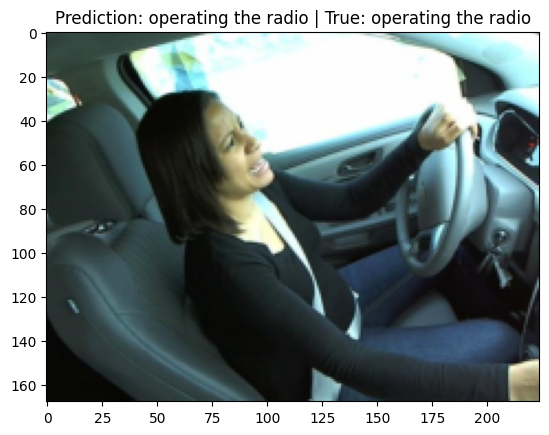

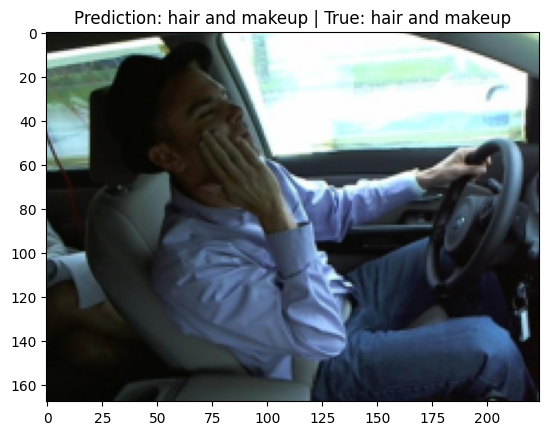

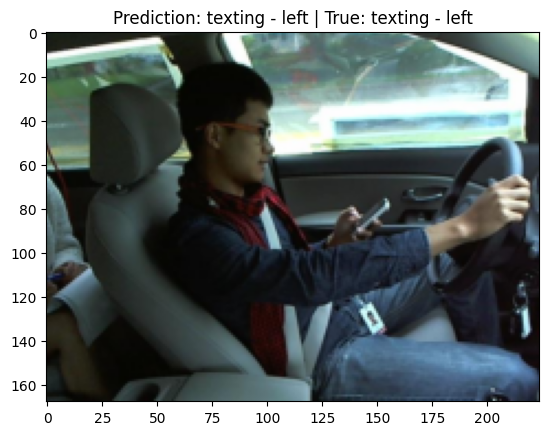

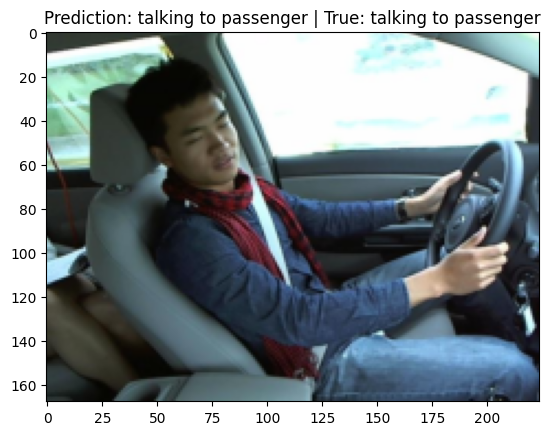

In [18]:
def display_prediction_and_truth(index, prediction, labels, imgs, config):
    predicted_class = config['dataset']['class_mapping']['c' + str(prediction.argmax(1)[index].item())]
    true_class = config['dataset']['class_mapping']['c' + str(labels[index].item())]

    plt.imshow(imgs[index].cpu().permute(1, 2, 0))
    plt.title(f"Prediction: {predicted_class} | True: {true_class}")
    plt.show()

#print all imgs
for i in range(len(imgs)):
    display_prediction_and_truth(i, prediction, labels, imgs, config)
    